In [160]:
#download the latest tweets 
!pip install searchtweets-v2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [161]:
from searchtweets import ResultStream, gen_request_parameters, load_credentials, collect_results
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [162]:
search_args = load_credentials(filename="/content/drive/MyDrive/M.L/twitter_keys_eg.yaml", yaml_key="search_tweets_v2")

In [163]:
#Hashtag to be analysed 
arguments = "#futuro -is:retweet -is:quote lang:it"
#columns 
metadata = ["created_at", "author_id", "source"]

In [164]:
query = gen_request_parameters(arguments,results_per_call=100, granularity=None, tweet_fields=",".join(metadata))
rs = ResultStream(request_parameters=query,
                    tweetify=False,
                    max_results=100,
                    max_pages=1,
                   max_tweets=500,
                    **search_args)
rs

ResultStream: 
	{
    "endpoint": "https:\/\/api.twitter.com\/2\/tweets\/search\/recent",
    "request_parameters": {
        "query": "#futuro -is:retweet -is:quote lang:it",
        "max_results": 100,
        "tweet.fields": "created_at,author_id,source"
    },
    "max_tweets": 500
}

In [165]:
tweets = list(rs.stream())

df_tweet = pd.DataFrame()
for page in tweets:
  df_tweet = df_tweet.append(pd.DataFrame(pd.json_normalize(page['data'])))
df_tweet[:5]

,created_at,id,text,edit_history_tweet_ids,source,author_id
0,2022-10-18T15:10:18.000Z,1582388608174284801,"Le parole sono un luogo della #pace, quelle ch...",[1582388608174284801],Twitter for iPhone,40453467
1,2022-10-18T13:45:16.000Z,1582367209330204672,RT:Cresce a livello globale il pessimismo sul ...,[1582367209330204672],BusinessCommunity.it,239736419
2,2022-10-18T13:35:21.000Z,1582364716525314048,⚠️ Lavori in corso per l'attività di #FiberCop...,[1582364716525314048],Twitter Web App,1376486167667937280
3,2022-10-18T12:32:01.000Z,1582348776026820610,Tra poco a #Como il primo incontro del nuovo #...,[1582348776026820610],Twitter for Android,2921836294
4,2022-10-18T11:47:53.000Z,1582337670314741761,Colloquio tra #aziende e #università per dare ...,[1582337670314741761],Twitter Web App,1322684712


In [166]:
len(df_tweet)

211

In [167]:
print(df_tweet.shape)

(211, 6)


In [168]:
#saving csv
df_tweet.to_csv("twitterscrapping.csv", index = False) 

In [169]:
#Displays the number of tweets for the source
res = df_tweet[["source", "id"]].groupby("source").count().reset_index().rename(columns={"id": "count"}).sort_values("count", ascending=False)
res

,source,count
16,Twitter Web App,65
17,Twitter for Android,54
19,Twitter for iPhone,35
14,The Tweeted Times,11
21,dlvr.it,7
18,Twitter for iPad,5
10,PostPickr,5
1,BusinessCommunity.it,4
15,TweetDeck,4
0,Blog2Social APP,3


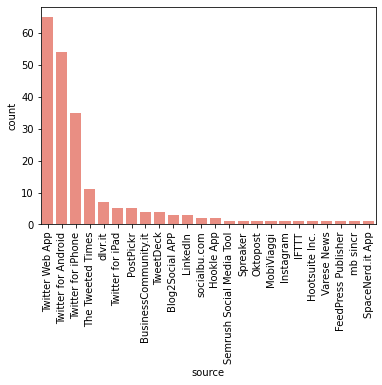

In [170]:
sns.barplot(x="source", y="count", data=res, color="salmon")
plt.xticks(rotation = 90)
plt.show()

In [171]:
example = df_tweet['text'].head()
example

0    Le parole sono un luogo della #pace, quelle ch...
1    RT:Cresce a livello globale il pessimismo sul ...
2    ⚠️ Lavori in corso per l'attività di #FiberCop...
3    Tra poco a #Como il primo incontro del nuovo #...
4    Colloquio tra #aziende e #università per dare ...
Name: text, dtype: object

In [172]:
#Sentiment e Emotion analysis

#installing feel_it https://huggingface.co/MilaNLProc/feel-it-italian-sentiment
!pip install feel_it

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [173]:
##import of SentimentClassifier
from feel_it import EmotionClassifier, SentimentClassifier

In [174]:
sentiment_classifier = SentimentClassifier()


In [175]:
sentiment_classifier.predict(["Evvai!!", "Che noia"])

['positive', 'negative']

In [176]:
##creating a new column
df_tweet["sentiment"] = sentiment_classifier.predict(list(df_tweet["text"]),batch_size=256)

In [177]:
positive=df_tweet[df_tweet["sentiment"] == 'positive']

In [178]:
negative=df_tweet[df_tweet["sentiment"] == 'negative']

In [179]:
#comparing number of positive and negative comments
df_com = df_tweet[["sentiment", "id"]].groupby("sentiment").count().reset_index().rename(columns={"id": "count"}).sort_values("count", ascending=False)
df_com

,sentiment,count
1,positive,151
0,negative,60


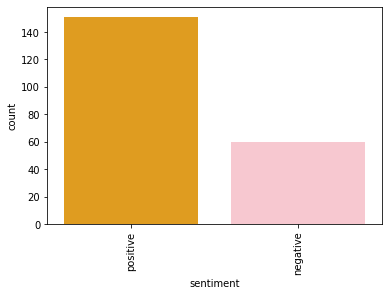

In [180]:
color=['orange','pink']
sns.set_palette(color)
sns.barplot(x="sentiment", y="count", data=df_com)
plt.xticks(rotation = 90)
plt.show()

In [181]:
for s, l in zip(df_tweet.text[:-5], df_tweet.sentiment[:-5]):
  print(l, "->", s)

positive -> Le parole sono un luogo della #pace, quelle che condividiamo come i più giovani ancora di più! Grazie per una giornata intensa al Festival Matota, a Tatjana Giorcelli, a @onnivori e quanti hanno disegnato un tratto di #futuro @Babelica_Tweet @peoplepubit https://t.co/AHUaC0qf1F
negative -> RT:Cresce a livello globale il pessimismo sul futuro delle imprese -  @RGrantThornton #recessione #imprese #inflazione #futuro https://t.co/WUaqwifRqo
positive -> ⚠️ Lavori in corso per l'attività di #FiberCop in #Puglia nel Comune di #Trani 👷

La rete del #futuro. Adesso. 🌐

#digitalizzazione #connettività #tlc https://t.co/YOKmTKq7c6
positive -> Tra poco a #Como il primo incontro del nuovo #annoaccademico all'#Università della #TerzaEtà Volta, parliamo del #futuro dell'#UE #dibatto #cittadini @Europarl_IT @europainitalia https://t.co/WMtAkQnHyC
positive -> Colloquio tra #aziende e #università per dare ai ragazzi competenze per rimanere nel nostro #Paese e crearsi una professione in un #

In [182]:
parole_pos = " ".join(df_tweet[df_tweet["sentiment"] == 'positive']['text'])


In [183]:
parole_neg = " ".join(df_tweet[df_tweet["sentiment"] == 'positive']['text'])


In [184]:
##removing some words and symbols
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('italian'))

['ad', 'al', 'allo', 'ai', 'agli', 'all', 'agl', 'alla', 'alle', 'con', 'col', 'coi', 'da', 'dal', 'dallo', 'dai', 'dagli', 'dall', 'dagl', 'dalla', 'dalle', 'di', 'del', 'dello', 'dei', 'degli', 'dell', 'degl', 'della', 'delle', 'in', 'nel', 'nello', 'nei', 'negli', 'nell', 'negl', 'nella', 'nelle', 'su', 'sul', 'sullo', 'sui', 'sugli', 'sull', 'sugl', 'sulla', 'sulle', 'per', 'tra', 'contro', 'io', 'tu', 'lui', 'lei', 'noi', 'voi', 'loro', 'mio', 'mia', 'miei', 'mie', 'tuo', 'tua', 'tuoi', 'tue', 'suo', 'sua', 'suoi', 'sue', 'nostro', 'nostra', 'nostri', 'nostre', 'vostro', 'vostra', 'vostri', 'vostre', 'mi', 'ti', 'ci', 'vi', 'lo', 'la', 'li', 'le', 'gli', 'ne', 'il', 'un', 'uno', 'una', 'ma', 'ed', 'se', 'perché', 'anche', 'come', 'dov', 'dove', 'che', 'chi', 'cui', 'non', 'più', 'quale', 'quanto', 'quanti', 'quanta', 'quante', 'quello', 'quelli', 'quella', 'quelle', 'questo', 'questi', 'questa', 'queste', 'si', 'tutto', 'tutti', 'a', 'c', 'e', 'i', 'l', 'o', 'ho', 'hai', 'ha', 'ab

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [185]:
import re
parole_pos,parole_neg = re.sub(r'https?:\/\/.*\/\w*', '', parole_pos),re.sub(r'https?:\/\/.*\/\w*', '', parole_neg)

parole_pos,parole_neg = re.sub(r'twitter', '', parole_pos),re.sub(r'twitter', '', parole_neg)
parole_pos,parole_neg = re.sub(r'Twitter', '', parole_pos),re.sub(r'Twitter', '', parole_neg)
parole_pos ,parole_neg= re.sub(r'futuro', '', parole_pos),re.sub(r'futuro', '', parole_neg)
parole_pos ,parole_neg= re.sub(r'Futuro', '', parole_pos),re.sub(r'Fututo', '', parole_neg)
parole_pos ,parole_neg= re.sub(r'italia', '', parole_pos),re.sub(r'italia', '', parole_neg)

parole_pos,parole_neg = re.sub(r'#', '', parole_pos),re.sub(r'#', '', parole_neg)
parole_pos,parole_neg = re.sub(r'@', '', parole_pos),re.sub(r'@', '', parole_neg)

In [186]:
#worldcloud for positive and negative comments
nltk.download('punkt')
from nltk.tokenize import word_tokenize

word_tokens_neg = word_tokenize(parole_neg)
word_tokens_pos = word_tokenize(parole_pos)
stop_words = set(stopwords.words('italian'))

filtered_sentence_pos = [w for w in word_tokens_pos if not w.lower() in stop_words]
filtered_sentence_neg = [w for w in word_tokens_neg if not w.lower() in stop_words]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


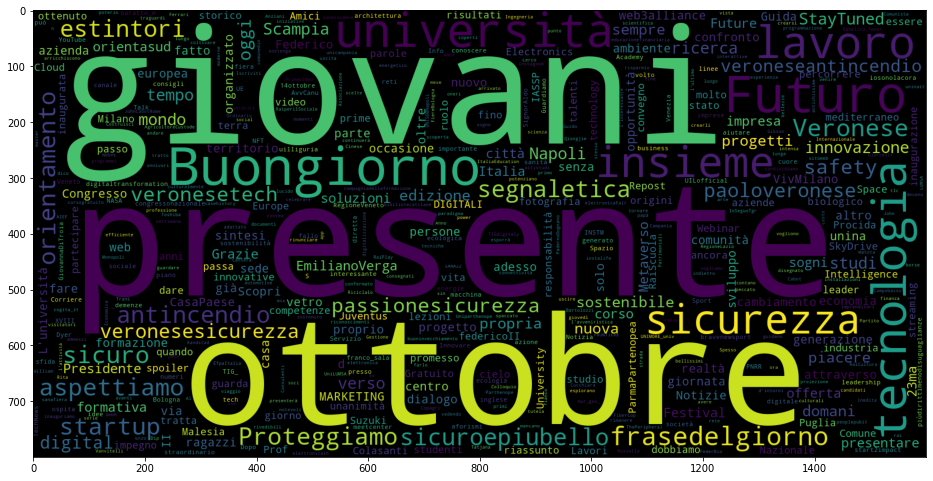

In [187]:
#most used words in negative comments
from wordcloud import WordCloud
plt.figure(figsize = (16,16))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800, collocations=False).generate(" ".join(filtered_sentence_neg))
plt.imshow(wc)

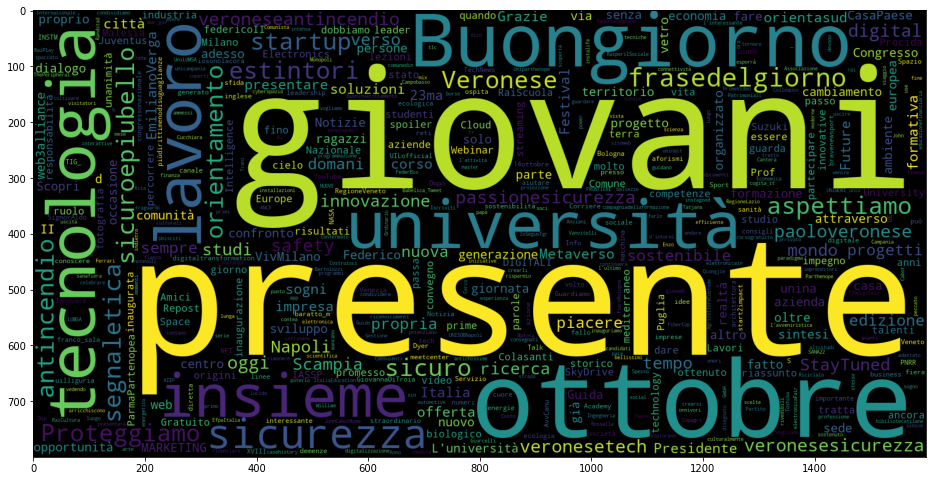

In [188]:
#most used words in positive comments
from wordcloud import WordCloud
plt.figure(figsize = (16,16))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800, collocations=False).generate(" ".join(filtered_sentence_pos))
plt.imshow(wc)

In [189]:
# Recovering data X
X = df_tweet['text']

# Recovering Labels y_label
y_label = df_tweet['sentiment']

In [190]:
#Transforming Labels
y = []

for label in y_label:
  if label == 'positive':
    y.append(1)
  else:
    y.append(0)

In [191]:
# splitting the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

In [192]:
from sklearn.base import TransformerMixin 
import string
punctuations = string.punctuation

#Custom transformer using spaCy 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}

# Basic utility function to clean the text 
def clean_text(text):     
    return text.translate(str.maketrans('', '', string.punctuation)).strip().lower()

In [193]:
predictors().fit_transform(["&Hello, world .,,."])

['hello world']

In [194]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
classifier = LinearSVC()

# Create the  pipeline to clean, vectorize, and classify 
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])



# Create model and measure accuracy, precision and recall
pipe.fit(X_train, y_train) 
pred_data = pipe.predict(X_test) 

for (sample, pred, sentence) in zip(y_test, pred_data, X_test):
    print (sample, pred, sentence) 
    
print ( "Accuracy:", accuracy_score(y_test, pred_data) )
print ( "Precision:", precision_score(y_test, pred_data) )
print ( "Recall: ", recall_score(y_test, pred_data, average='weighted'))


1 1 Il Ministro del Futuro https://t.co/DtMj6YNaKP #futuro #istruzione #scuola
0 1 Ci sono tre minacce che incombono su di noi. Le individua Ian Bremmer, politologo statunitense, nel nuovo #libro intitolato Il potere della crisi. Ecco la nostra recensione della domenica!

https://t.co/flqFfyAszQ

#libridaleggere #investireneimegatrend #futuro #evoluzione https://t.co/eMIZAflbUp
1 1 https://t.co/whu4yYmPZ0
Amici di #PadernoDugnano #Milano e d'intorni, vi aspettiamo giovedì 27 ottobre h 21:00, per Cantera #coltivare talenti nel mondo del #lavoro #compagniadellaformazione #bibiliotecatilane #futuro #giovani
1 1 Primo lavoro di gruppo oggi a #DirLav2022 : è importante costruire legami fra noi #studenti… è su questi che si basa il nostro #futuro.
1 1 Stiamo vivendo un cambiamento epocale.Tra pochi anni la #Cina diventerà la prima potenza mondiale.
 L'#Italia dovrà ridefinire il suo ruolo e la propria #vision per il #futuro. 
Che ne pensate? https://t.co/mfMOJH5G9P
0 1 “ Senza Titolo "2022
h